In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020r
from source.python.cnn.models import Zrimec2020c
from source.python.cnn.models import Washburn2019r
from source.python.cnn.models import Washburn2019c

from source.python.dataset import dataset_split
from source.python.dataset import dataset_utils
from source.python.cnn     import cnn_model
from source.python.cnn     import cnn_mutation
from source.python.cnn     import cnn_plot
from source.python.cnn     import cnn_utils
from source.python.io      import loader
from source.python.io      import writer
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Define output and inputs

FILTER_ID      = 2
VERBOSE        = False
FEATURES       = True
GENERATOR      = 'group'

MODEL_ARCH     = 'zrimec'
MODEL_MODE     = 'regression'
MODEL_PARAMS   = 0
MODEL_EPOCHS   = 25

TARGET_GROUP   = 'global'
TARGET_TYPE    = 'mean'
TARGET_EXPLODE = False
TARGET_FILTER  = None

SEQUENCE_TYPE  = 'transcript-2150'
SEQUENCE_END   = None
SEQUENCE_START = None

PRETRAIN_FLAG  = False
PRETRAIN_PATH  = None

In [5]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	parser.add_argument('--target_group',   type = str,         default = 'global',          choices = ['tissue', 'group', 'age', 'global', 'perturbation'])
	parser.add_argument('--target_type',    type = str,         default = 'mean',            choices = ['mean', 'max'])
	parser.add_argument('--target_explode', type = str_of_bool, default = False)
	parser.add_argument('--target_filter',  type = str_or_none, default = None)
	parser.add_argument('--model_arch',     type = str,         default = 'zrimec',          choices = ['zrimec', 'washburn'])
	parser.add_argument('--model_epochs',   type = int,         default = 250)
	parser.add_argument('--model_params',   type = int_or_none, default = None)
	parser.add_argument('--model_mode',     type = str,         default = 'regression',      choices = ['regression', 'classification'])
	parser.add_argument('--filter_id',      type = int,         default = 0)
	parser.add_argument('--generator',      type = str,         default = 'group',           choices = ['stratified', 'group', 'random'])
	parser.add_argument('--features',       type = str_of_bool, default = False)
	parser.add_argument('--sequence_start', type = int_or_none, default = None)
	parser.add_argument('--sequence_end',   type = int_or_none, default = None)
	parser.add_argument('--sequence_type',  type = str,         default = 'transcript-2150', choices = ['transcript-2150', 'transcript-6150', 'promoter-full-5000', 'promoter-utr5-5000']),
	parser.add_argument('--model_pretrain', type = str_of_bool, default = False)

	args = vars(parser.parse_args())

	TARGET_GROUP   = args['target_group']
	TARGET_TYPE    = args['target_type']
	TARGET_EXPLODE = args['target_explode']
	TARGET_FILTER  = args['target_filter']
	MODEL_EPOCHS   = args['model_epochs']
	MODEL_PARAMS   = args['model_params']
	MODEL_MODE     = args['model_mode']
	FILTER_ID      = args['filter_id']
	GENERATOR      = args['generator']
	FEATURES       = args['features']
	SEQUENCE_START = args['sequence_start']
	SEQUENCE_END   = args['sequence_end']
	SEQUENCE_TYPE  = args['sequence_type']
	PRETRAIN_FLAG  = args['model_pretrain']

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

Running as .ipynb



In [6]:
# Setup some directory paths.

SUBFOLDER = 'filter' + str(FILTER_ID)
FOLDER    = '{}-f{}-{}'.format(MODEL_ARCH, FILTER_ID, MODEL_MODE[0])

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp08-cnn',     FOLDER)
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata', SUBFOLDER)
RES_NBP04 = os.path.join(OUT,      'nbp04-feature', SUBFOLDER)
RES_NBP05 = os.path.join(OUT,      'nbp05-target',  SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP02}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp08-cnn\zrimec-f2-r
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp08-cnn\zrimec-f2-r\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp08-cnn\zrimec-f2-r\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter2
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter2
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter2



In [7]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 15.705 GB



In [8]:
# Define sequence paths

if SEQUENCE_TYPE == 'transcript-6150'    :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-6150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-6150-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-6150.fasta')

if SEQUENCE_TYPE == 'transcript-2150'    :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-2150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-2150-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-2150.fasta')

if SEQUENCE_TYPE == 'promoter-full-5000' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-promoter-full-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-promoter-full-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-promoter-full.fasta')

if SEQUENCE_TYPE == 'promoter-utr5-5000' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-promoter-utr5-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-promoter-utr5-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-promoter-utr5.fasta')

if MODEL_ARCH == 'zrimec'   : model_config = os.path.join(RES, 'tuner', 'zrimec.json')
if MODEL_ARCH == 'washburn' : model_config = os.path.join(RES, 'tuner', 'washburn.json')

In [9]:
# Define pretrained model path

PRETRAIN_PATH = os.path.join(RES, 'models', SEQUENCE_TYPE, MODEL_ARCH + '-scerevisiae.pth')

In [10]:
# Load the input transcript features

sequence_keep = loader.load_fasta(
	filename  = sequence_keep,
	to_string = True
)

sequence_drop = loader.load_fasta(
	filename  = sequence_drop,
	to_string = True
)

mutation_sequence = loader.load_fasta(
	filename  = mutation_keep,
	to_string = True
)

mutation_feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-base.npz')
)

feature_base_keep = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-keep.npz')
)

feature_base_drop = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-drop.npz')
)

model_config = loader.load_json(
	filename = model_config
)

# 2. Config

In [11]:
# Create final report

final_report = dict()

In [12]:
# Single global config

CONFIG = {
	'core/device'             : DEVICE,
	'core/random'             : None,
	'core/rootdir'            : ROOT,
	'core/verbose'            : VERBOSE,
	'core/plots'              : 5,
	'dataset/expanddim'       : 0,
	'dataset/sequence/start'  : SEQUENCE_START,
	'dataset/sequence/end'    : SEQUENCE_END,
	'dataset/sequence/type'   : SEQUENCE_TYPE,
	'dataset/split/generator' : GENERATOR,
	'dataset/split/test'      : 0.2,
	'dataset/split/valid'     : 0.2,
	'model/arch'              : MODEL_ARCH,
	'model/epochs'            : MODEL_EPOCHS,
	'model/features'          : FEATURES,
	'model/input/channels'    : 1,
	'model/input/features'    : None,
	'model/input/height'      : 4,
	'model/input/width'       : 2150,
	'model/mode'              : MODEL_MODE,
	'model/output/explode'    : TARGET_EXPLODE,
	'model/output/filter'     : TARGET_FILTER,
	'model/output/heads'      : None,
	'model/output/size'       : None,
	'model/output/target'     : TARGET_GROUP,
	'model/output/type'       : TARGET_TYPE,
	'model/params/id'         : MODEL_PARAMS,
	'pretrain/flag'           : PRETRAIN_FLAG,
	'pretrain/path'           : PRETRAIN_PATH
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

if CONFIG['model/arch'] == 'zrimec'   : CONFIG['dataset/expanddim'] = None
if CONFIG['model/arch'] == 'washburn' : CONFIG['dataset/expanddim'] = 0

In [13]:
# Update specific params

if CONFIG['model/params/id'] is not None and CONFIG['model/params/id'] >= 0 :
	CONFIG.update(model_config[CONFIG['model/params/id']])

	CONFIG['dataset/batch/train'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/valid'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/test']  = CONFIG['dataset/batch_size']

In [14]:
# Update configuration

if CONFIG['model/mode'] == 'regression'     : CONFIG['criterion/name'] = 'corrected-mse'
if CONFIG['model/mode'] == 'classification' : CONFIG['criterion/name'] = 'entropy'

In [15]:
# Prints

print('Output Target : {}'.format(CONFIG['model/output/target']))
print('Output Type   : {}'.format(CONFIG['model/output/type']))
print('Use Features  : {}'.format(CONFIG['model/features']))
print('Random Seed   : {}'.format(CONFIG['core/random']))
print()

Output Target : global
Output Type   : mean
Use Features  : True
Random Seed   : 33905191



# 3. Dataloader

## 3.1 Normal

In [16]:
# Create dataset

dataset_keep, dataframe_keep, target_value_keep, target_order_keep = dataset_utils.get_dataset(
	config    = CONFIG,
	sequence  = sequence_keep,
	feature   = feature_base_keep,
	directory = RES_NBP05,
	cached    = None,
	start     = SEQUENCE_START,
	end       = SEQUENCE_END,
	filename  = 'mapping-grouped-keep.pkl'
)

dataset_drop, dataframe_drop, target_value_drop, target_order_drop = dataset_utils.get_dataset(
	config    = CONFIG,
	sequence  = sequence_drop,
	feature   = feature_base_drop,
	directory = RES_NBP05,
	cached    = None,
	start     = SEQUENCE_START,
	end       = SEQUENCE_END,
	filename  = 'mapping-grouped-drop.pkl'
)

print('Input Features : {}'.format(CONFIG['model/input/features']))
print('Output Size    : {}'.format(CONFIG['model/output/size']))
print('Output Heads   : {}'.format(CONFIG['model/output/heads']))
print()

CONFIG['model/fc3/features'] = CONFIG['model/output/size']
CONFIG['model/fc3/heads']    = CONFIG['model/output/heads']

Input Features : 72
Output Size    : 1
Output Heads   : None



In [17]:
# Create dataloader

dataloaders_keep = dataset_utils.to_dataloaders(
	dataset     = dataset_keep,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/valid'],
		'test'  : CONFIG['dataset/split/test']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

train_dataloader_keep = dataloaders_keep[0]
valid_dataloader_keep = dataloaders_keep[1]
test_dataloader_keep  = dataloaders_keep[2]

dataloaders_drop = dataset_utils.to_dataloaders(
	dataset     = dataset_drop,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : 0.0,
		'test'  : 0.0
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

test_dataloader_drop = dataloaders_drop[0]

dataloaders_full = dataset_utils.to_dataloaders(
	dataset     = dataset_keep,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : 0.0,
		'test'  : 0.0
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

test_dataloader_full = dataloaders_full[0]

In [18]:
# Display train dataloader

dataset_utils.show_dataloader(
	dataloader = train_dataloader_keep,
	verbose    = CONFIG['core/verbose']
)

In [19]:
# Display valid dataloader

dataset_utils.show_dataloader(
	dataloader = valid_dataloader_keep,
	verbose    = CONFIG['core/verbose']
)

In [20]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader_keep,
	verbose    = CONFIG['core/verbose']
)

In [21]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader_drop,
	verbose    = CONFIG['core/verbose']
)

In [22]:
# Display full dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader_full,
	verbose    = CONFIG['core/verbose']
)

## 3.2 Mutation

In [23]:
# Update mutation features

if 'Feature' in dataframe_keep.columns :
	mutation_feature_base_new = dict()

	for x in mutation_feature_base.keys() :
		df = dataframe_keep.loc[dataframe_keep['Transcript'] == x.split('-')[0]]

		for index, row in df.iterrows() :
			key = index + '-' + x.split('-')[-1]
			val = numpy.concatenate((mutation_feature_base[x], row['Feature']))

			mutation_feature_base_new[key] = val

	mutation_feature_base = mutation_feature_base_new

In [24]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_sequence,
	features    = mutation_feature_base,
	targets     = target_value_keep,
	expand_dims = CONFIG['dataset/expanddim'],
	start       = SEQUENCE_START,
	end         = SEQUENCE_END
)

In [25]:
# Display mutation dataloader

dataset_utils.show_dataloader(
	dataloader = mutation_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Structure

In [26]:
# Create and display the model structure

if CONFIG['model/arch'] == 'zrimec' :
	if CONFIG['model/mode'] == 'regression'     : model = Zrimec2020r(params = CONFIG)
	if CONFIG['model/mode'] == 'classification' : model = Zrimec2020c(params = CONFIG, binary = False)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

if CONFIG['model/arch'] == 'washburn' :
	if CONFIG['model/mode'] == 'regression'     : model = Washburn2019r(params = CONFIG)
	if CONFIG['model/mode'] == 'classification' : model = Washburn2019c(params = CONFIG, binary = False)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_channels = CONFIG['model/input/channels'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

print()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [64, 4, 2150]             [64, 1]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 512]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 256, 2150]           5,376
│    └─LeakyReLU: 2-2                    [64, 256, 2150]           [64, 256, 2150]           --
│    └─BatchNorm1d: 2-3                  [64, 256, 2150]           [64, 256, 2150]           512
│    └─Dropout: 2-4                      [64, 256, 2150]           [64, 256, 2150]           --
│    └─MaxPool1d: 2-5                    [64, 256, 2150]           [64, 256, 717]            --
│    └─Conv1d: 2-6                       [64, 256, 717]            [64, 64, 717]             180,288
│    └─LeakyReLU: 2-7                    [64, 64, 717]             [64, 64, 717]             --
│    └─BatchNorm1d: 2-8   

In [27]:
# Convert the model to double and initialize weights and biases

if CONFIG['pretrain/flag'] :
	model = cnn_model.load_from_pretrained(
		filename = os.path.join(CONFIG['pretrain/path']),
		model    = model,
		strict   = False
	)

	model = model.double()

else :
	model = model.double()
	model = model.apply(cnn_model.he_uniform_weight)
	model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [28]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'smae'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'smae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape',  output_size = CONFIG['model/output/size']),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape', output_size = CONFIG['model/output/size']),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2',    output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'auroc'     : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',     task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'confusion' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'confusion', task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'f1'        : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',        task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'jaccardi'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'jaccardi',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'matthews'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews',  task = 'multiclass', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.3 Parameters

In [29]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG | {
		'criterion/threshold' : 0.20
	},
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader_keep,
	'valid_dataloader' : valid_dataloader_keep,
	'test_dataloader'  : test_dataloader_keep
}

## 4.4 Train

In [30]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

## 4.5 Visualization

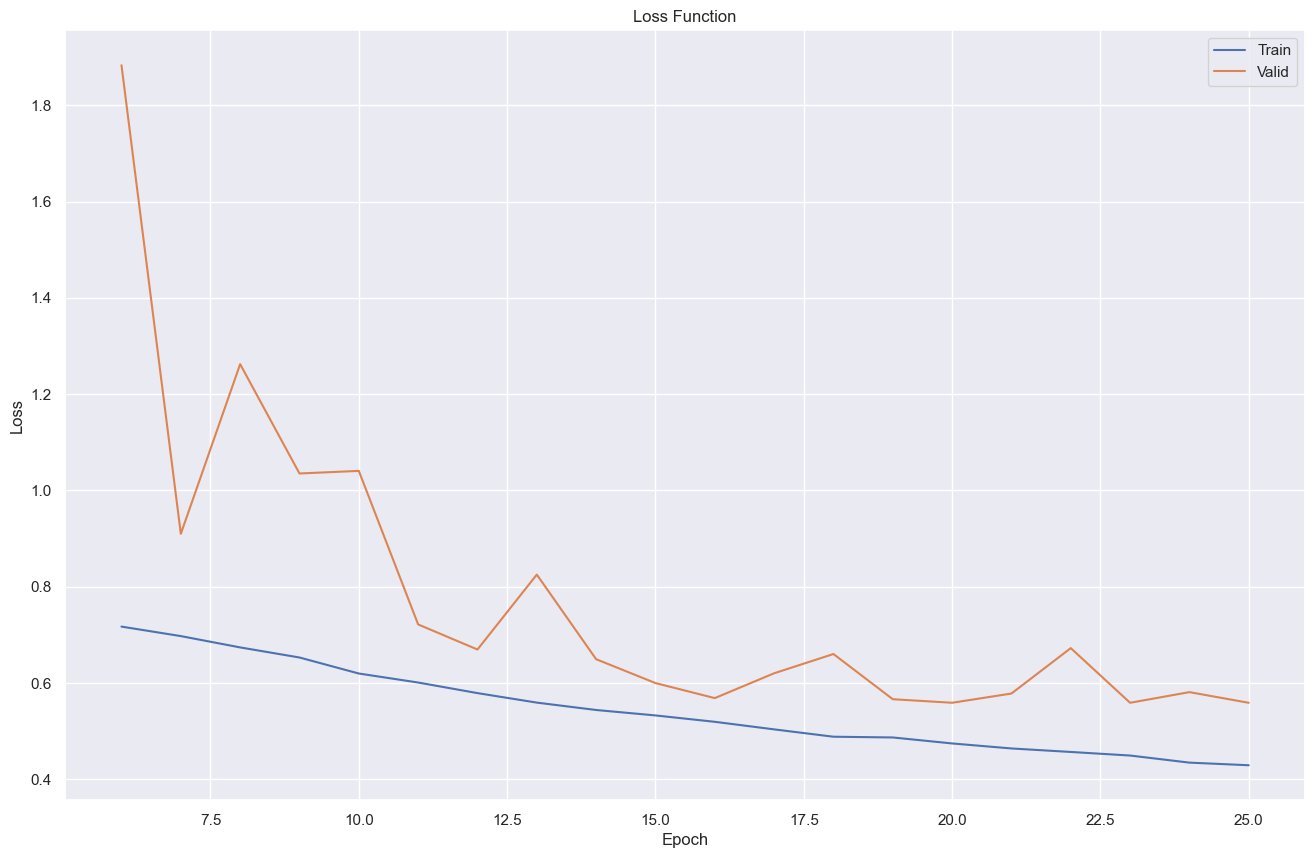

In [31]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report       = report,
	title        = 'Loss Function',
	filename     = os.path.join(OUT_PLOT, model.__name__),
	limit_bot    = None,
	limit_top    = None,
	start_index  = CONFIG['core/plots']
)

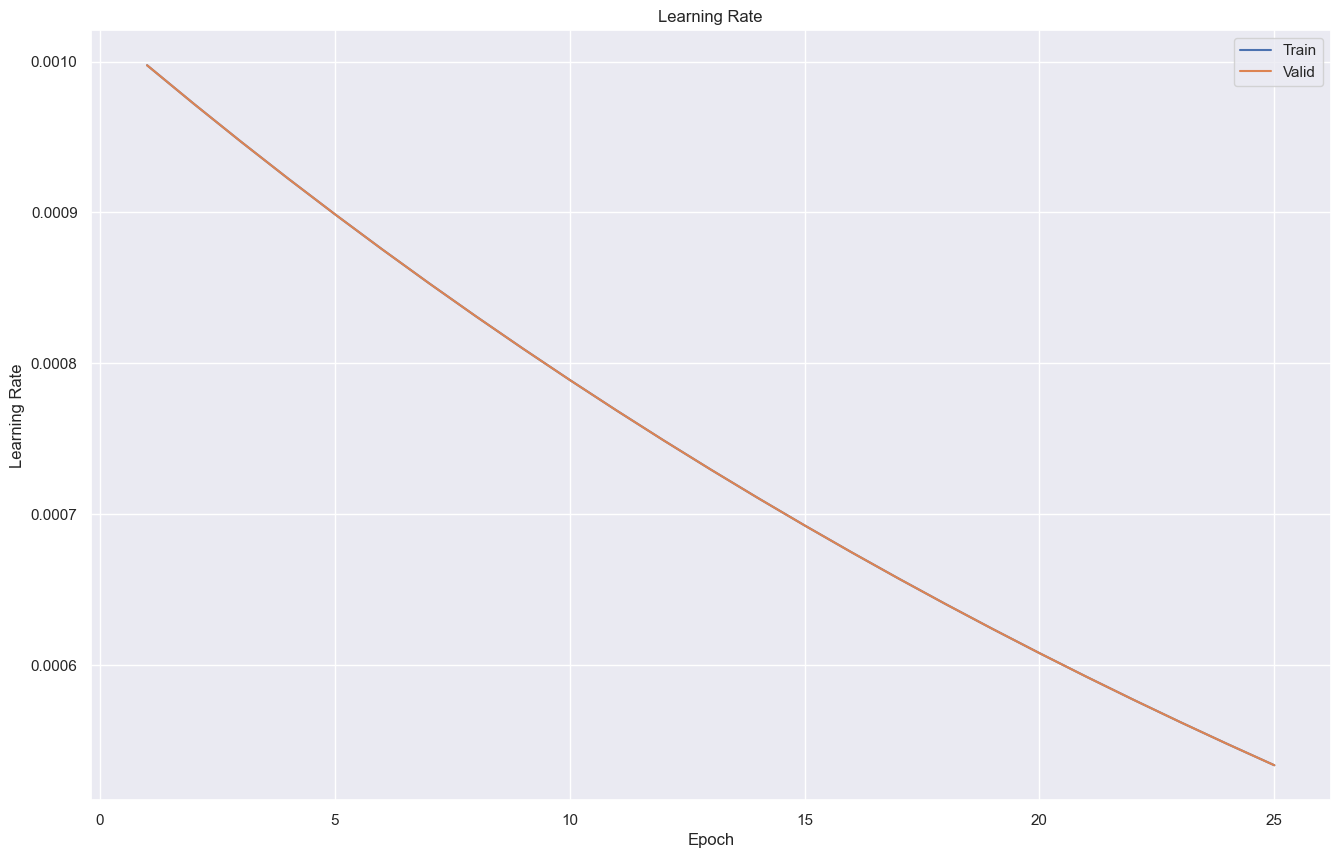

In [32]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report      = report,
	title       = 'Learning Rate',
	filename    = os.path.join(OUT_PLOT, model.__name__),
	limit_bot   = None,
	limit_top   = None,
	start_index = None
)

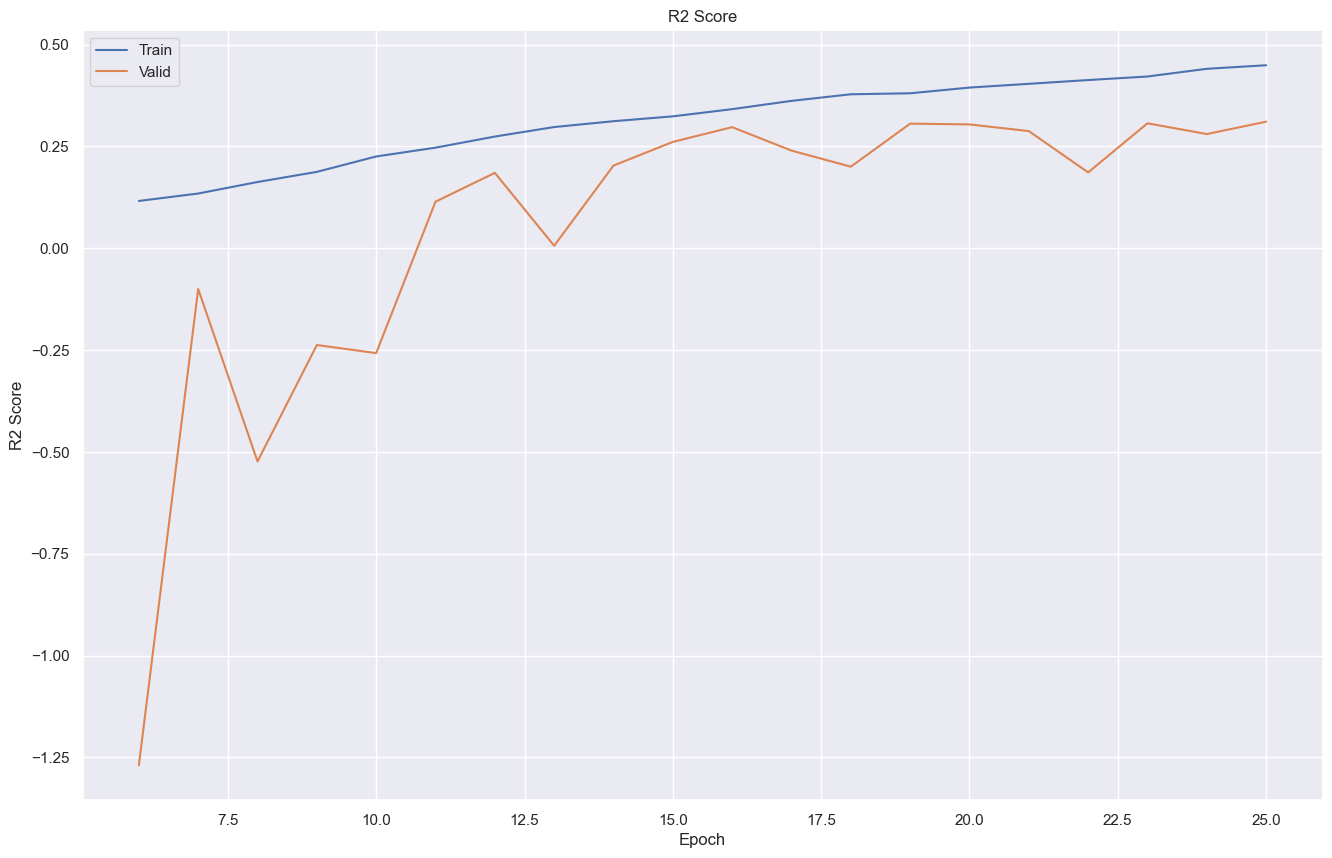

In [33]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report       = report,
		title        = 'R2 Score',
		filename     = os.path.join(OUT_PLOT, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report       = report,
		title        = 'Accuracy',
		filename     = os.path.join(OUT_PLOT, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

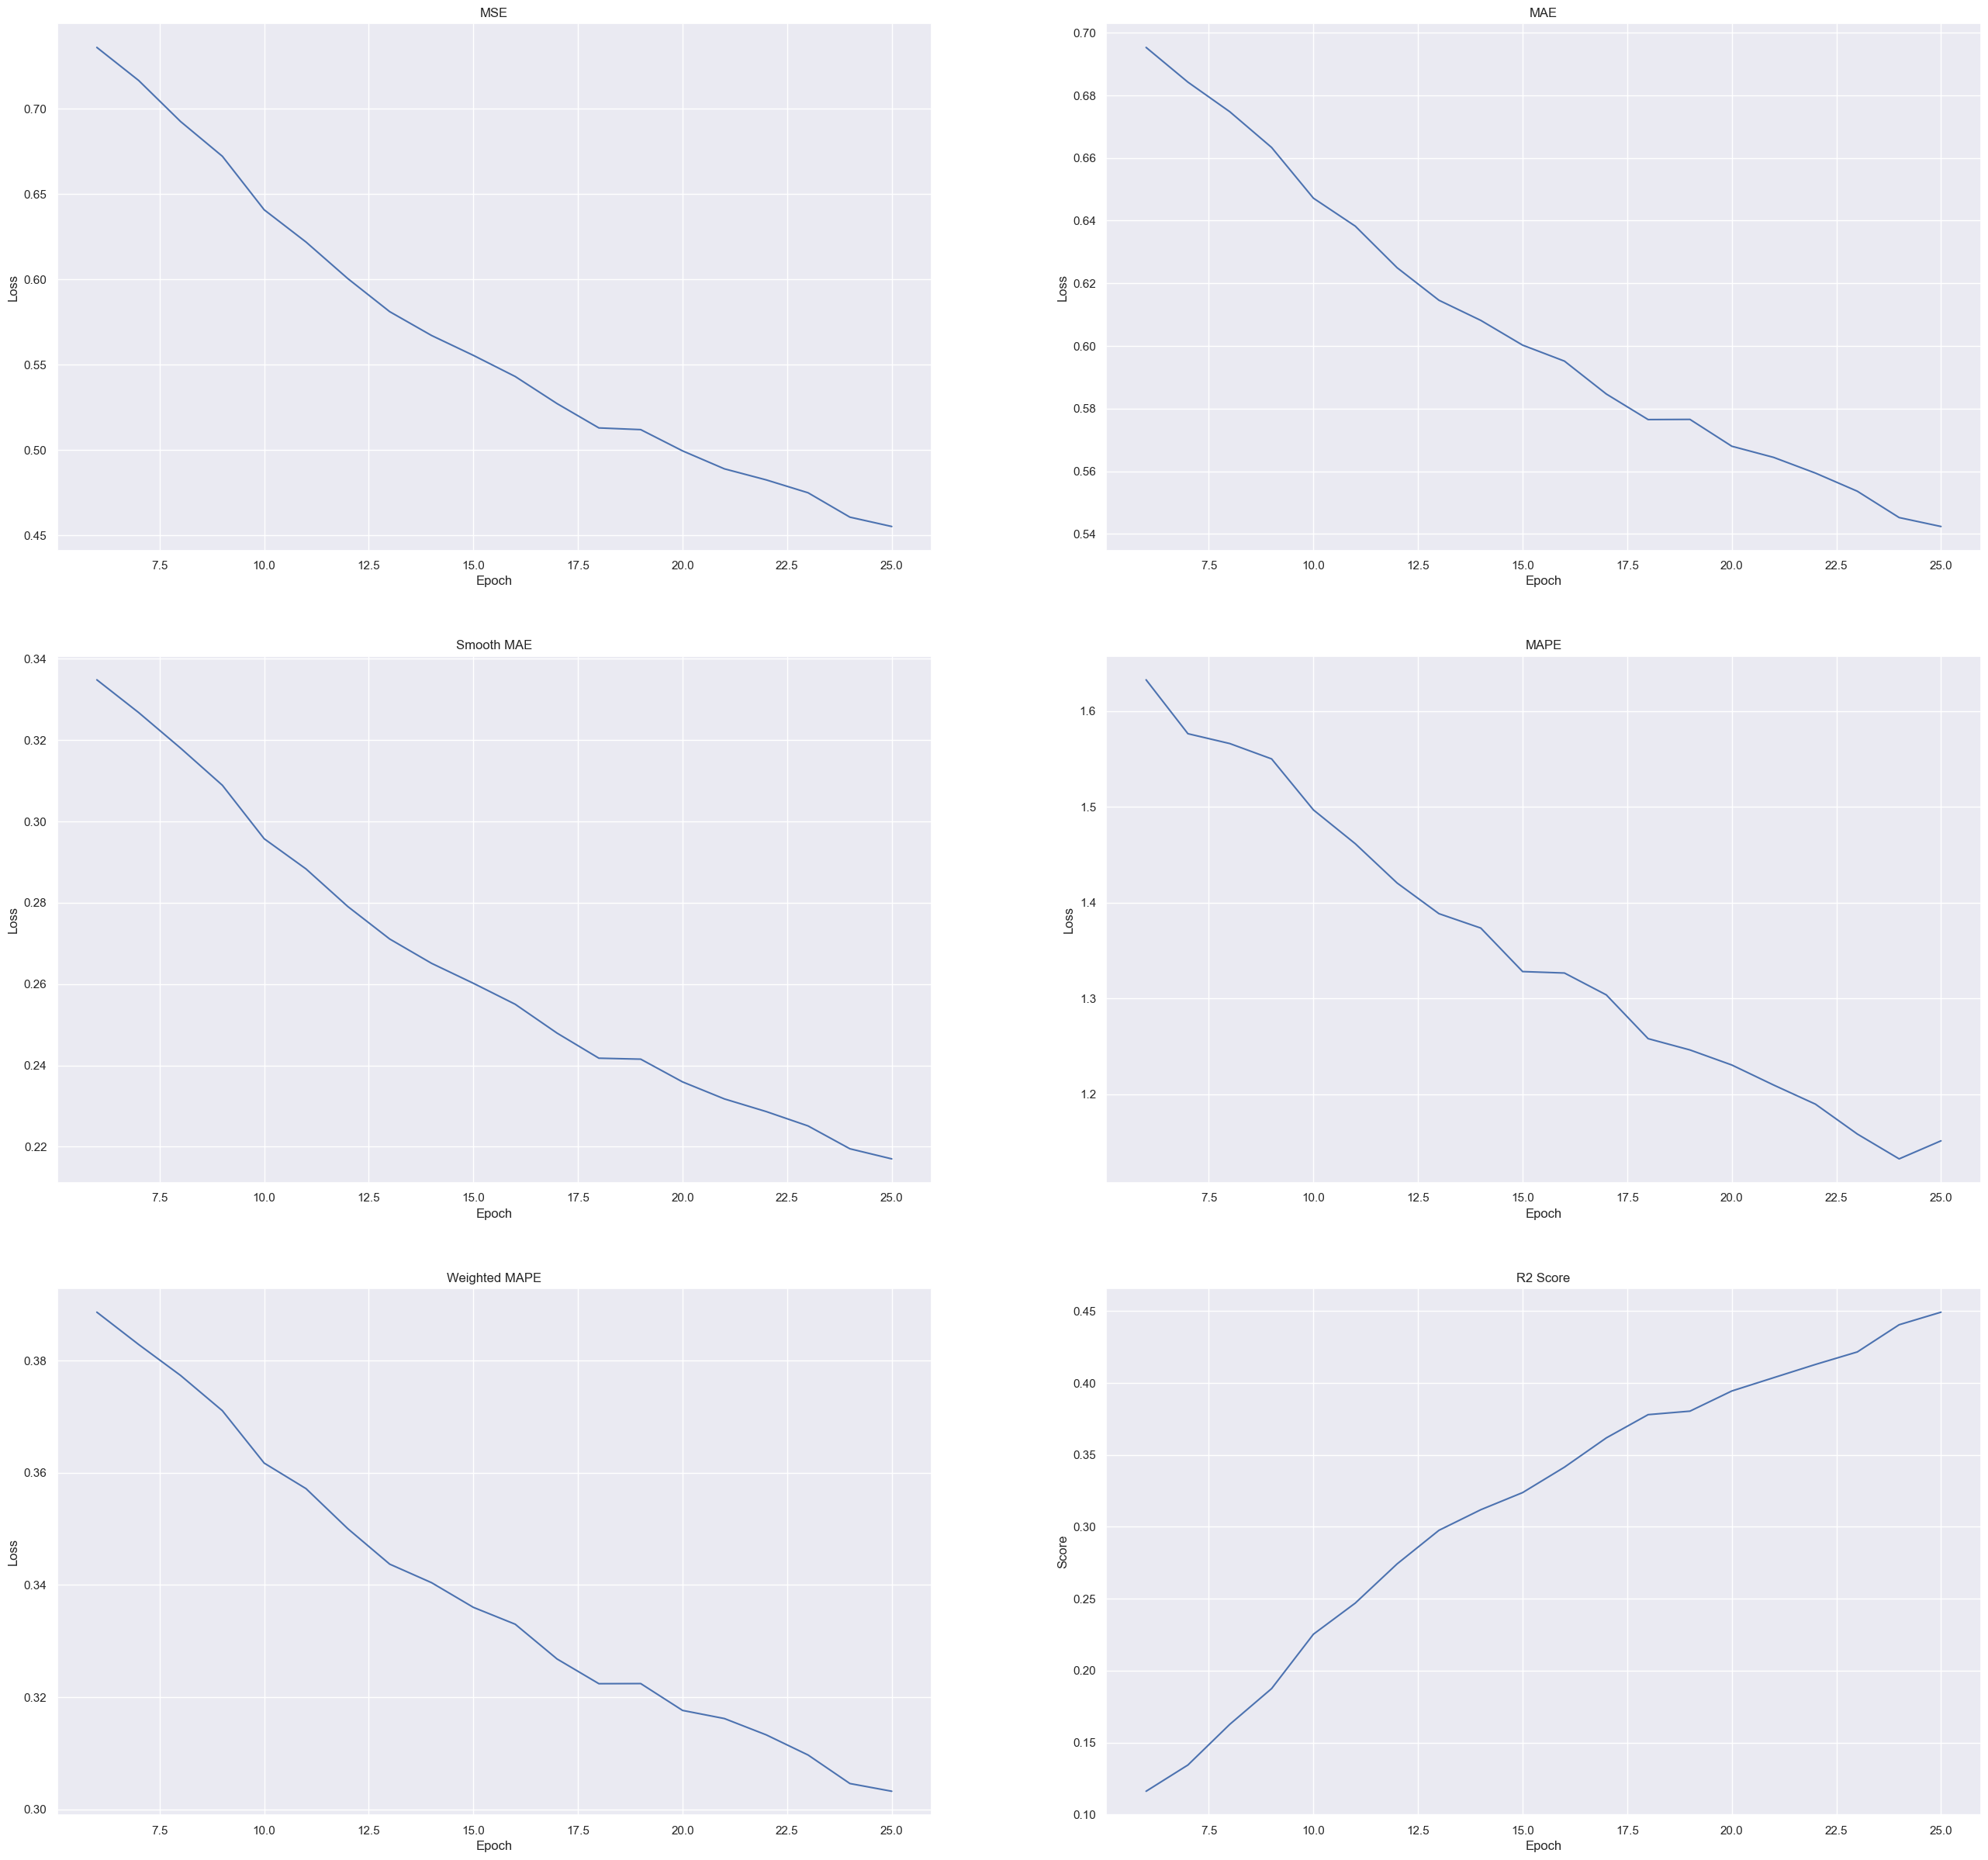

In [34]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'train',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-train'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

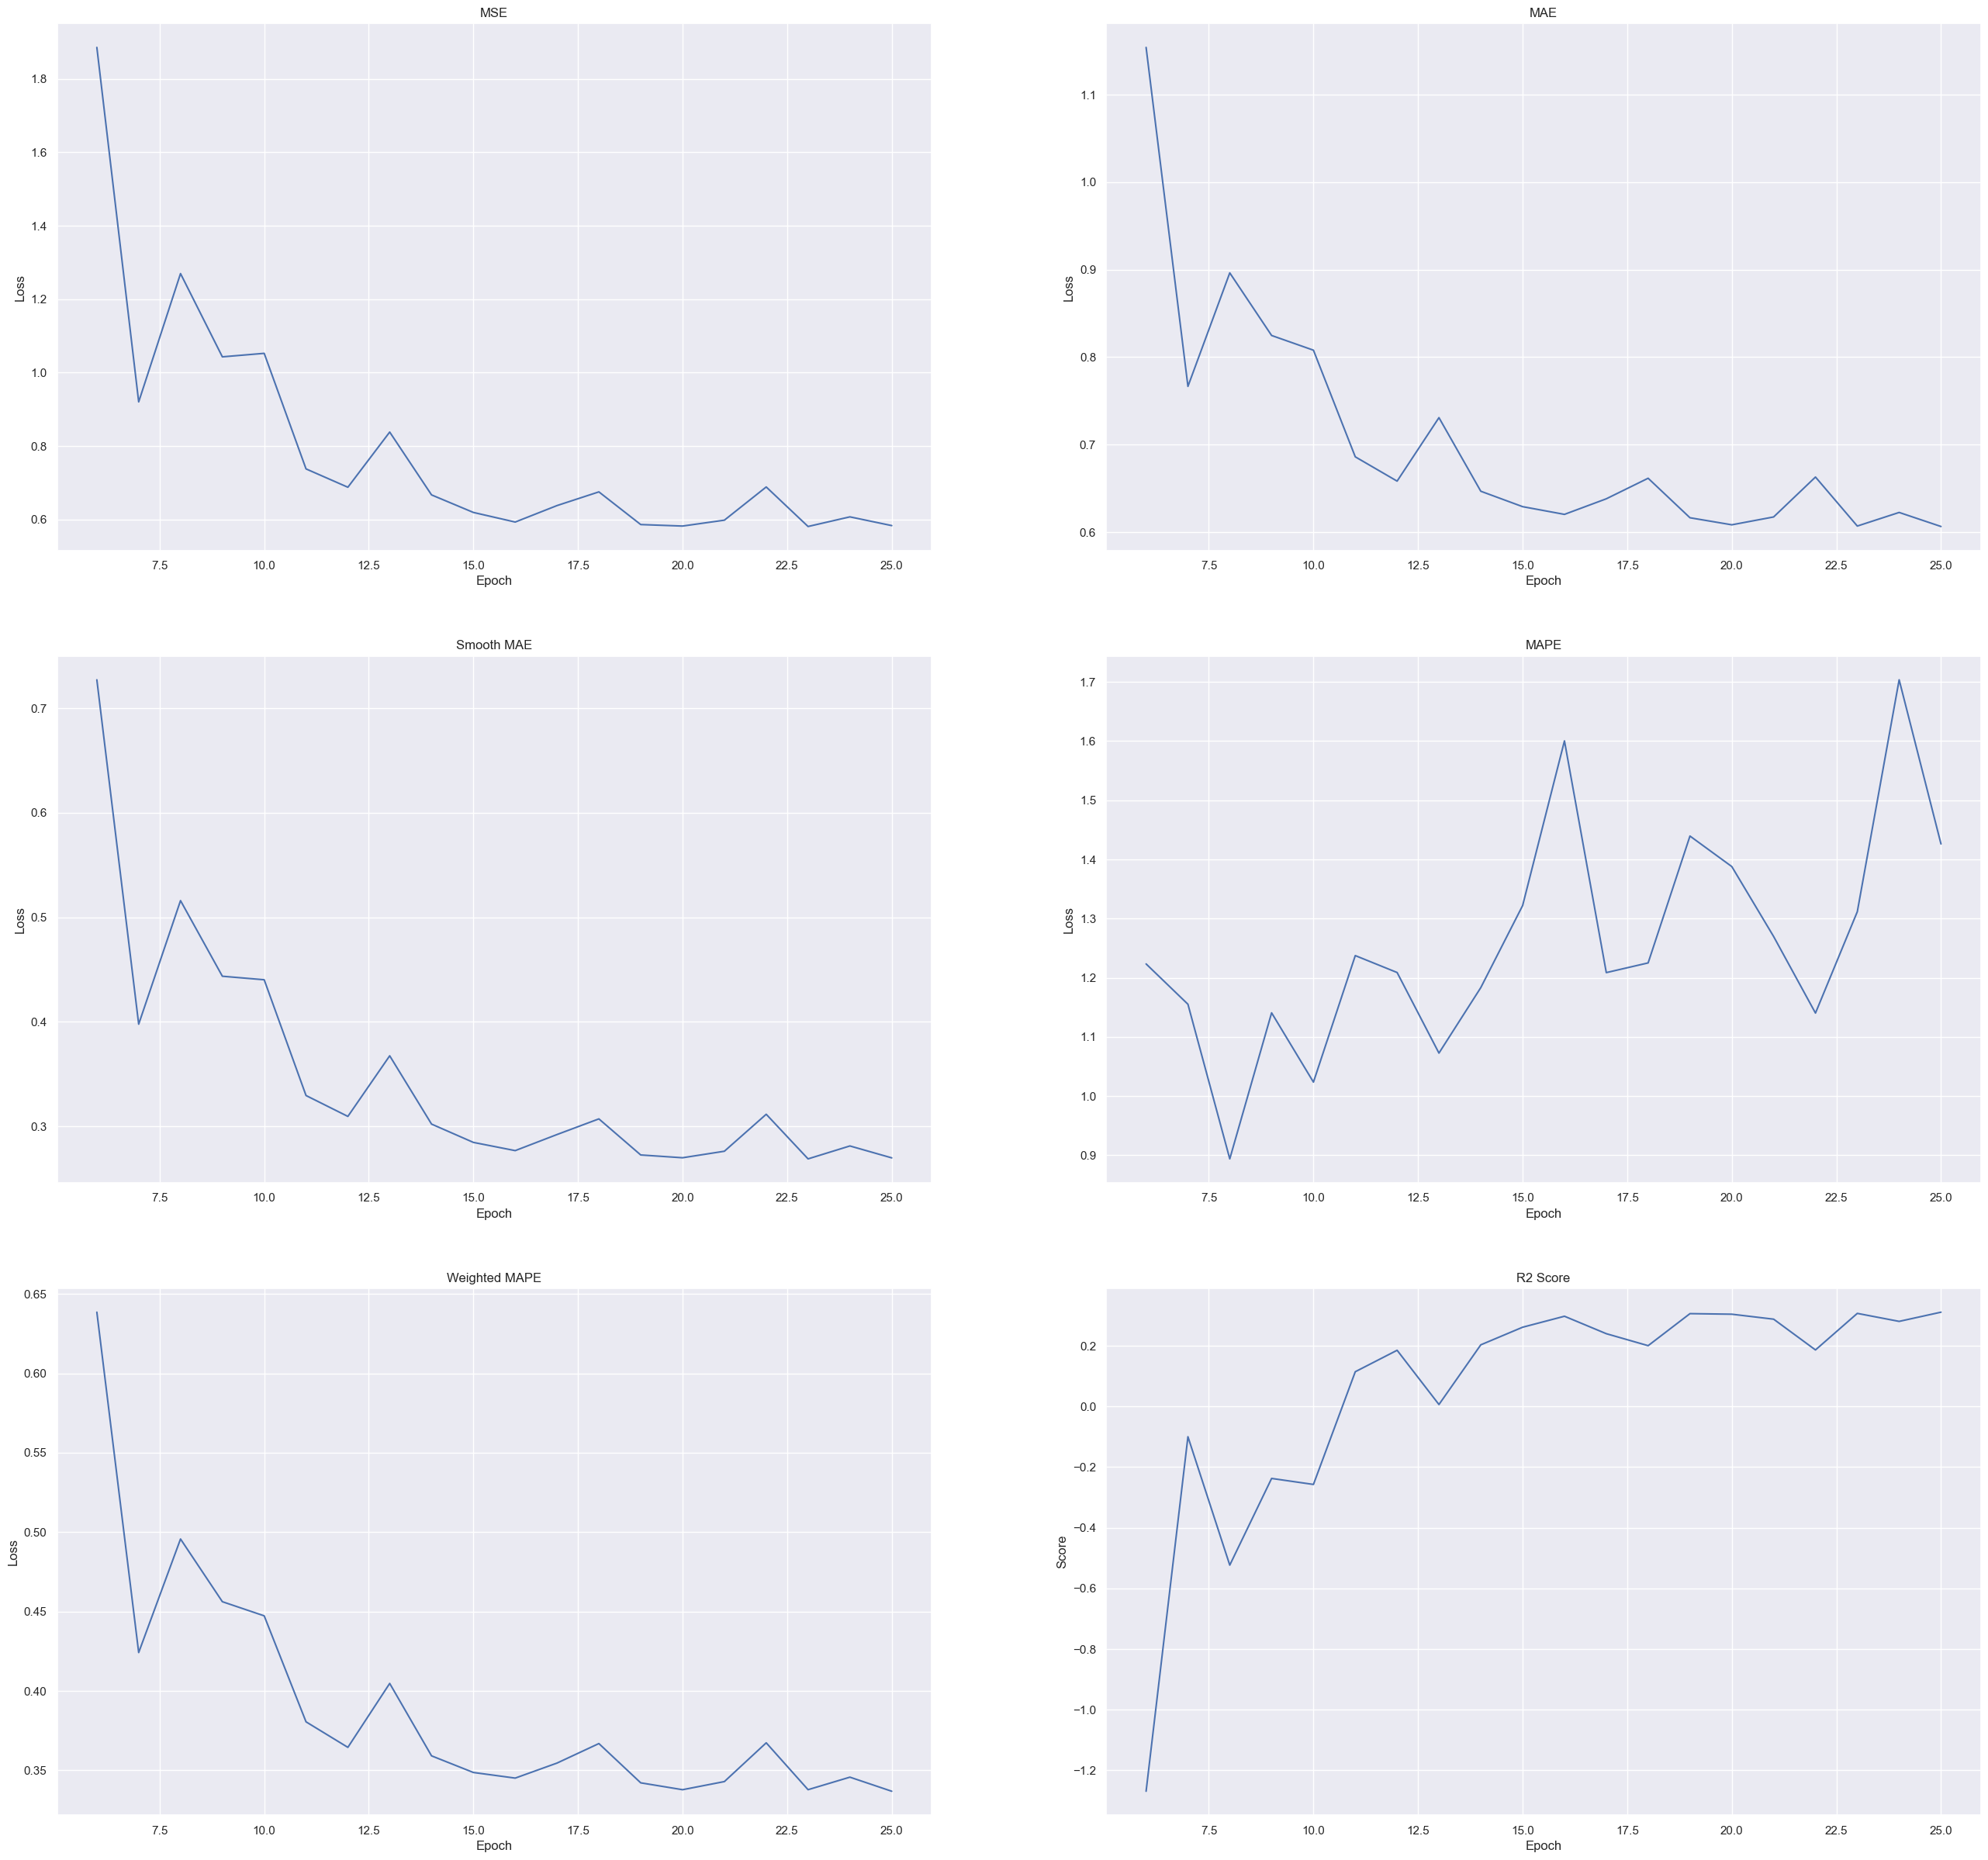

In [35]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'valid',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-valid'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [36]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 25
 Loss : 0.55872



<All keys matched successfully>

In [37]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

Mode   : evaluation/last/test
R2     :    0.29519
MAE    :    0.60911
MSE    :    0.58032
MAPE   :    1.28898
WMAPE  :    0.34354



In [38]:
# Evaluate the full model on drop test

if CONFIG['model/mode'] == 'regression' :
	report_drop, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_drop
		},
		report = final_report,
		mode   = 'evaluation/last/drop'
	)

if CONFIG['model/mode'] == 'classification' :
	report_drop, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_drop
		},
		report = final_report,
		mode   = 'evaluation/last/drop'
	)

Mode   : evaluation/last/drop
R2     :  -55.75491
MAE    :    0.94883
MSE    :    1.14680
MAPE   :   30.07617
WMAPE  :    6.91434



In [39]:
# Evaluate the full model on full test

if CONFIG['model/mode'] == 'regression' :
	report_full, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_full
		},
		report = final_report,
		mode   = 'evaluation/last/full'
	)

if CONFIG['model/mode'] == 'classification' :
	report_full, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_full
		},
		report = final_report,
		mode   = 'evaluation/last/full'
	)

Mode   : evaluation/last/full
R2     :    0.48384
MAE    :    0.52242
MSE    :    0.42764
MAPE   :    1.14010
WMAPE  :    0.29221



## 5.2 Best Model

### 5.2.1 Evaluation

In [40]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/best/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/best/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 25
 Loss : 0.55872



<All keys matched successfully>

In [41]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

Mode   : evaluation/best/test
R2     :    0.29290
MAE    :    0.60851
MSE    :    0.57972
MAPE   :    1.27154
WMAPE  :    0.34220



In [42]:
# Evaluate the full model on drop test

if CONFIG['model/mode'] == 'regression' :
	report_drop, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_drop
		},
		report = final_report,
		mode   = 'evaluation/best/drop'
	)

if CONFIG['model/mode'] == 'classification' :
	report_drop, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_drop
		},
		report = final_report,
		mode   = 'evaluation/best/drop'
	)

Mode   : evaluation/best/drop
R2     :  -54.65370
MAE    :    0.95020
MSE    :    1.14972
MAPE   :   30.12368
WMAPE  :    6.79806



In [43]:
# Evaluate the full model on drop test

if CONFIG['model/mode'] == 'regression' :
	report_full, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_full
		},
		report = final_report,
		mode   = 'evaluation/best/full'
	)

if CONFIG['model/mode'] == 'classification' :
	report_full, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_full
		},
		report = final_report,
		mode   = 'evaluation/best/full'
	)

Mode   : evaluation/best/full
R2     :    0.48096
MAE    :    0.52258
MSE    :    0.42777
MAPE   :    1.14088
WMAPE  :    0.29216



### 5.2.2 Custom

In [44]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_keep,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_keep,
		n      = 2
	)

 Key : AT1G26720.1
True : [ 0.65615]
Pred : [ 1.80662]
 MAE : [ 1.15047]
 MSE : [ 1.32358]
  R2 : [ 0.30910]

 Key : AT5G27120.1
True : [ 2.74736]
Pred : [ 1.94842]
 MAE : [ 0.79895]
 MSE : [ 0.63831]
  R2 : [ 0.16045]



In [45]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_full,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_full,
		n      = 2
	)

 Key : AT4G11521.1
True : [ 1.05398]
Pred : [ 1.75413]
 MAE : [ 0.70015]
 MSE : [ 0.49021]
  R2 : [ 0.44799]

 Key : AT3G14870.2
True : [ 1.35878]
Pred : [ 1.14316]
 MAE : [ 0.21562]
 MSE : [ 0.04649]
  R2 : [ 0.51050]



### 5.2.3 Visualization

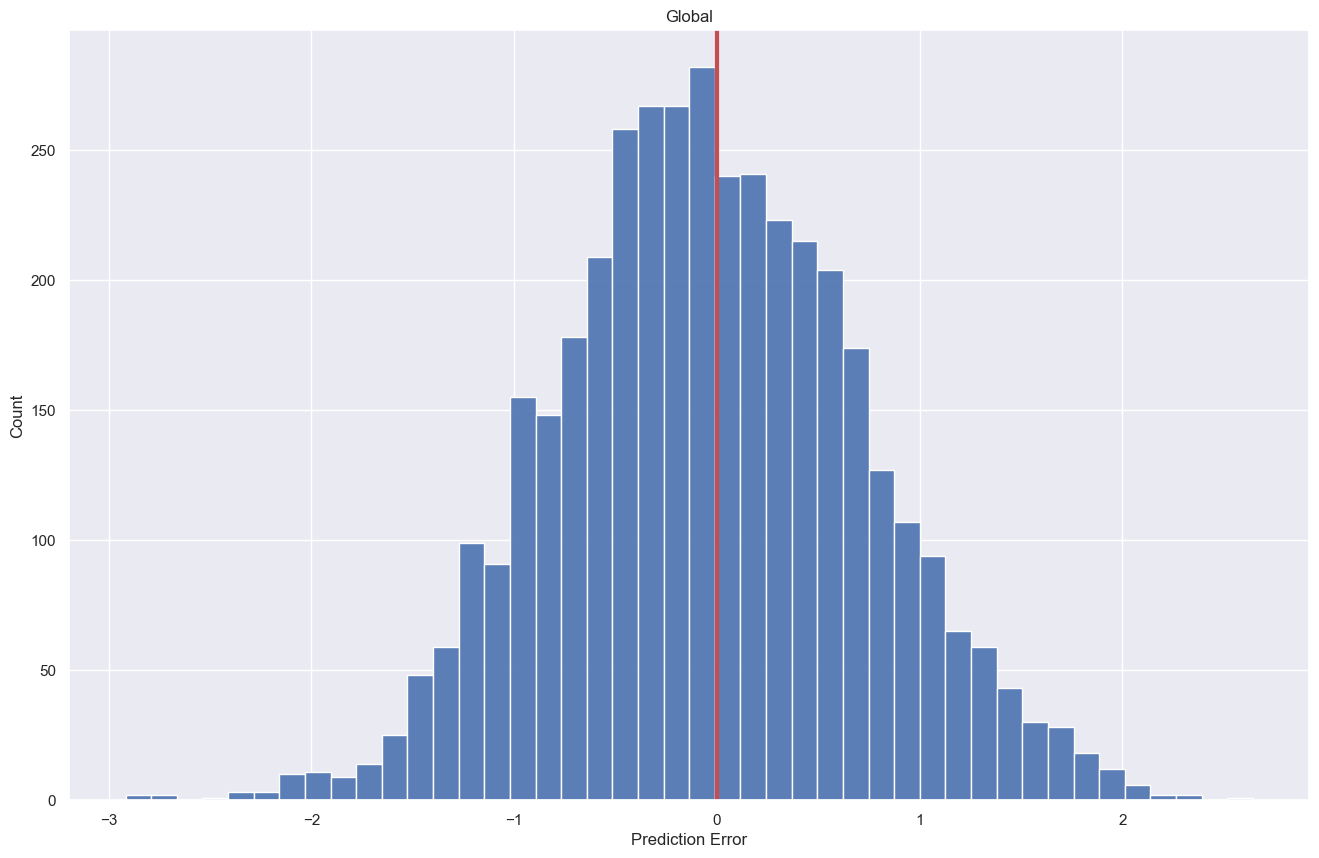

In [46]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_keep,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-keep-best')
	)

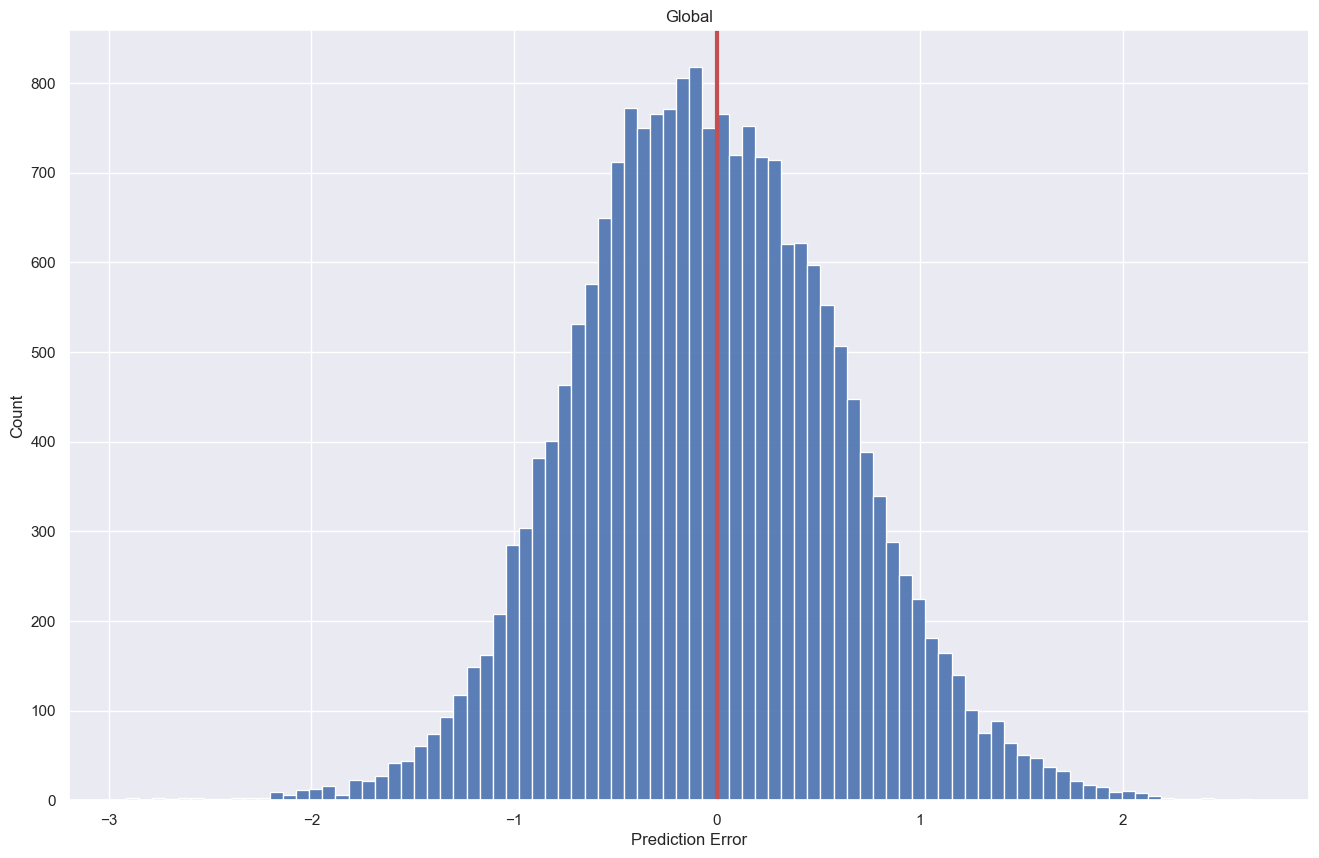

In [47]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_full,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-full-best')
	)

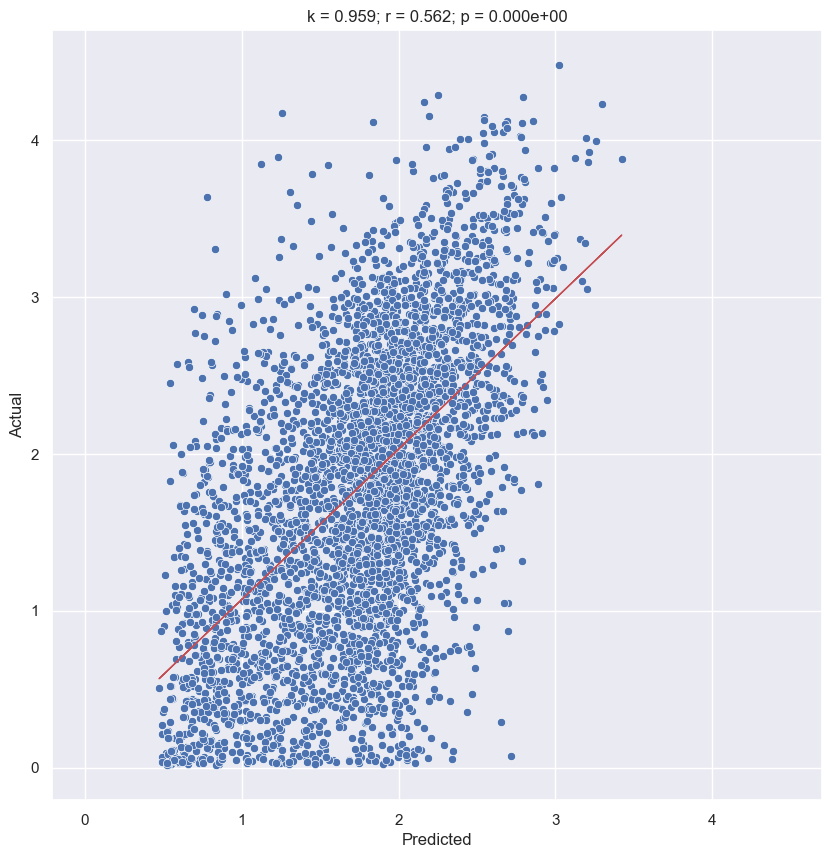

In [48]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_keep,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-keep-best')
	)

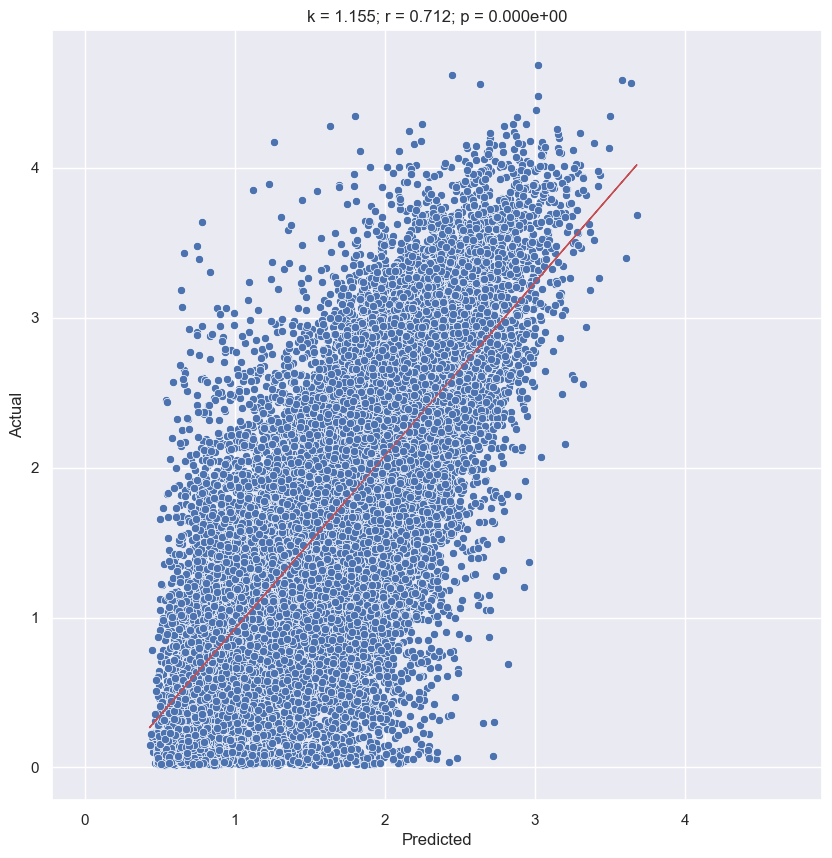

In [49]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_full,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-full-best')
	)

# 6 Mutation

## 6.1 Evaluation

In [50]:
# Evaluate the mutations

if CONFIG['model/mode'] == 'regression' :
	report_muta, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : mutation_dataloader,
			'metrics' : {
				'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse').to(DEVICE),
				'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae').to(DEVICE)
			}
		},
		report = final_report,
		mode   = 'mutation/best/'
	)

if CONFIG['model/mode'] == 'classification' :
	report_muta, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params | {
			'test_dataloader' : mutation_dataloader,
			'metrics' : {
				'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy' ).to(DEVICE),
				'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy', n_classes = CONFIG['model/output/size']).to(DEVICE)
			}
		},
		report = final_report,
		mode   = 'mutation/best/'
	)

Mode   : mutation/best/
MAE    :    0.61908
MSE    :    0.59847



In [51]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report_muta)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))
print()

Transcripts : 25
Mutations   : 6
Variants    : 20



In [52]:
# Print mutations

print(' ' + ' '.join('{:>20s}'.format(x) if i % 5 != 0 else '{:>20s}'.format(x) + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

          AT5G20590.1          AT3G14940.1          AT5G50480.1          AT1G16960.1          AT5G44635.1
          AT2G38860.1          AT1G63230.1          AT4G00050.3          AT5G44310.2          AT3G18130.1
          AT4G22666.1          AT1G80850.1          AT2G37380.1          AT1G14790.1          AT1G32410.3
          AT1G58230.3          AT2G19180.1          AT4G13100.7          AT4G27160.1          AT5G60520.1
          AT1G04280.1          AT4G14290.1          AT1G68070.1          AT5G60990.1          AT2G05540.1



## 6.2 Visualization

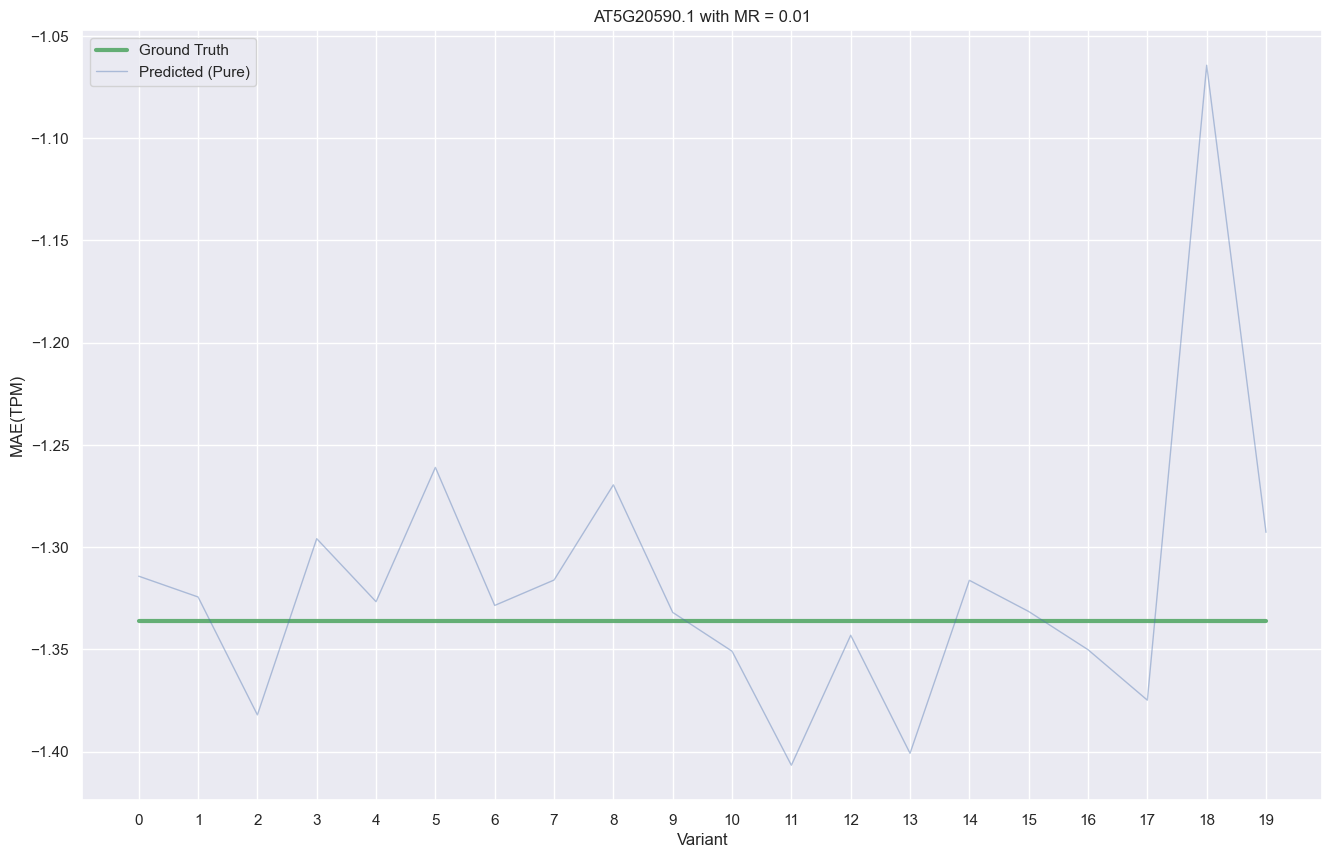

In [53]:
# Plot single transcript mutation variant predictions

if CONFIG['model/mode'] == 'regression' :
	cnn_mutation.plot_mutation_regression(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M01',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m01')
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_mutation.plot_mutation_classification(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M01',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m01')
	)

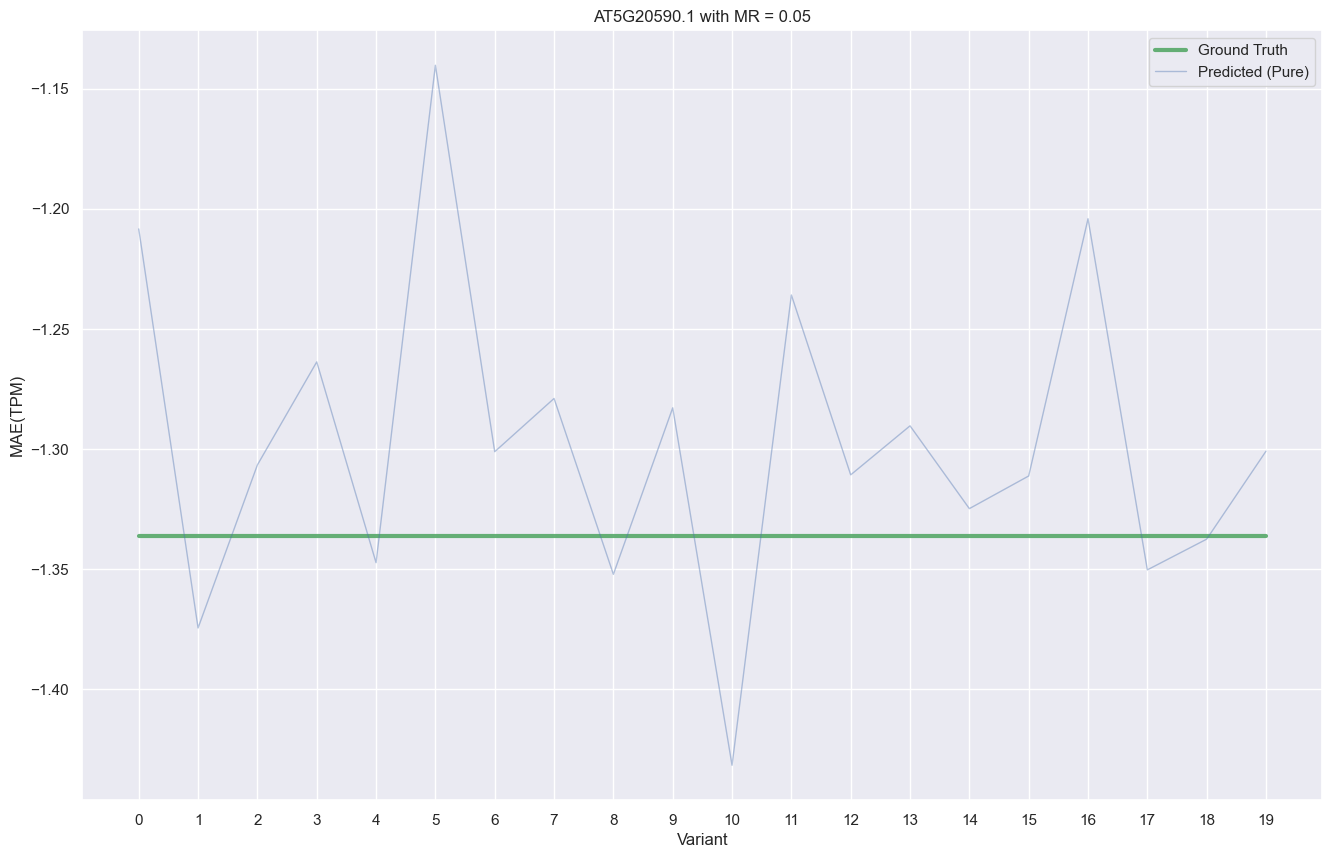

In [54]:
# Plot single transcript mutation variant predictions

if CONFIG['model/mode'] == 'regression' :
	cnn_mutation.plot_mutation_regression(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M05',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m05')
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_mutation.plot_mutation_classification(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M05',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m05')
	)

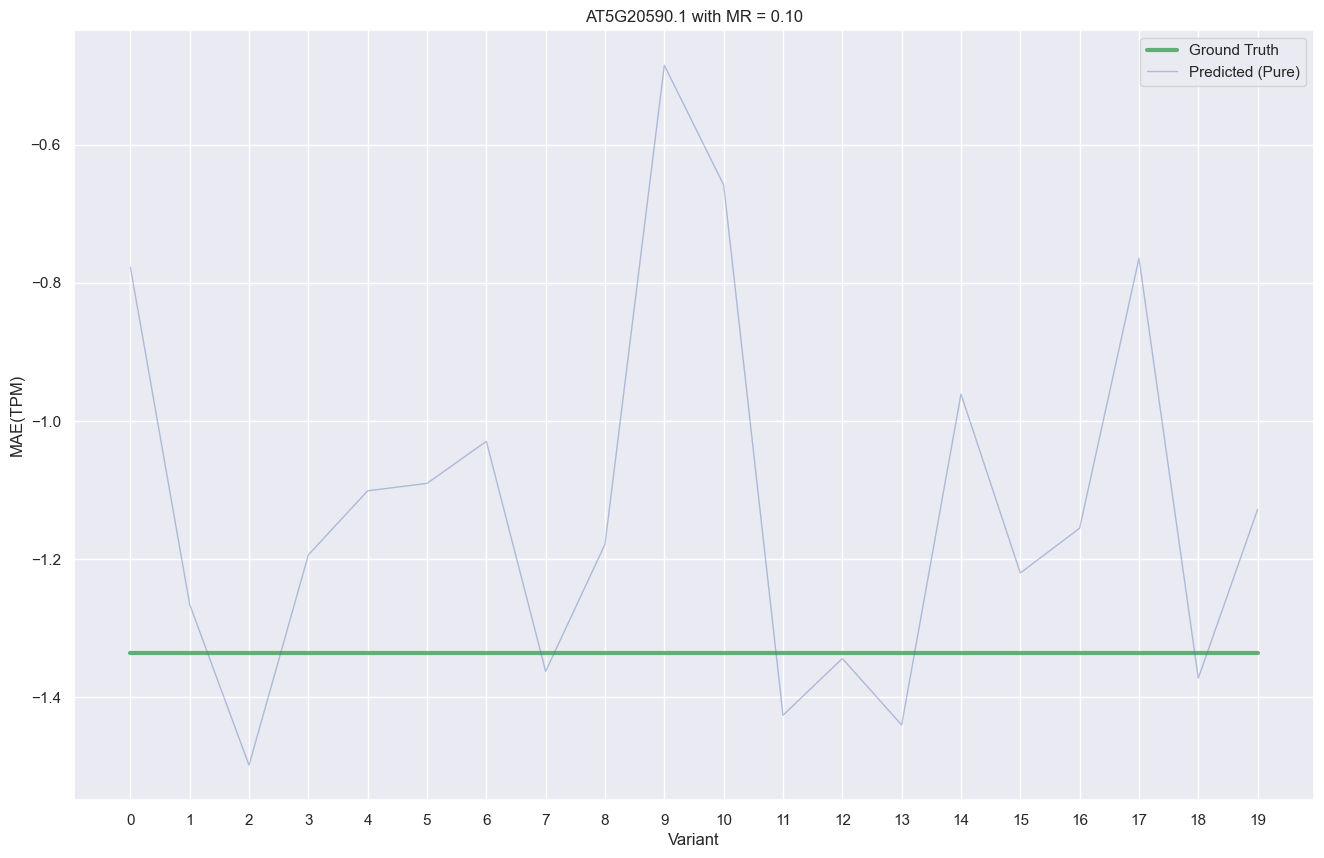

In [55]:
# Plot single transcript mutation variant predictions

if CONFIG['model/mode'] == 'regression' :
	cnn_mutation.plot_mutation_regression(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M10',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m10')
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_mutation.plot_mutation_classification(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M10',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m05')
	)

# 7. Save

In [56]:
# Convert reports from numpy array to lists

def ensure_json_validity (item) :
	if   isinstance(item, dict)          : pass
	elif isinstance(item, list)          : return item
	elif isinstance(item, numpy.ndarray) : return item.tolist()
	elif isinstance(item, float)         : return item
	elif isinstance(item, int)           : return item
	elif isinstance(item, str)           : return item
	else                                 : return None

	data = dict()

	for key in item.keys() :
		data[key] = ensure_json_validity(item[key])

	return data

report_keep = ensure_json_validity(report_keep)
report_drop = ensure_json_validity(report_drop)
report_full = ensure_json_validity(report_full)
report_muta = ensure_json_validity(report_muta)

In [57]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA, 'report.json')
)

writer.write_json(
	data     = report_keep,
	filename = os.path.join(OUT_DATA, 'report_keep.json')
)

writer.write_json(
	data     = report_drop,
	filename = os.path.join(OUT_DATA, 'report_drop.json')
)

writer.write_json(
	data     = report_full,
	filename = os.path.join(OUT_DATA, 'report_full.json')
)

writer.write_json(
	data     = report_muta,
	filename = os.path.join(OUT_DATA, 'report_muta.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA, 'config.json')
)